In [24]:
%matplotlib inline

import os
import psycopg2
import seaborn as sns
import pandas as pd
import random
import numpy as np
# from ggplot2 import *

import datetime
from matplotlib import pyplot as plt
from dateutil import relativedelta
from __future__ import division

from pymongo import MongoClient

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

os.sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

from shared.coverage_charts import exploration
from shared.corr_charts import plot
from shared.fill_charts import plot_fill

## Log into PSQL
DB_NAME = os.environ['DB_NAME']
DB_HOST = os.environ['DB_HOST']
DB_USER = os.environ['DB_USER']
DB_PASS = os.environ['DB_PASS']
credentials = (DB_NAME, DB_USER, DB_HOST, DB_PASS)
psql = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s' options='-c statement_timeout=200000'" % credentials)

## Log into redshift. 
#RED_NAME = os.environ['REDSHIFT_NAME']
#RED_HOST = os.environ['REDSHIFT_HOST']
#RED_USER = os.environ['REDSHIFT_USER']
#RED_PASS = os.environ['REDSHIFT_PASS']
#RED_PORT = os.environ['REDSHIFT_PORT']
#r_credentials = (RED_NAME, RED_USER, RED_HOST, RED_PASS, RED_PORT)
#rpsql = psycopg2.connect("dbname='%s' user='%s' host='%s' password='%s' port='%s'" % r_credentials)

## Log into Mongo.
#USER = os.environ['MONGO_USER']
#PASS = os.environ['MONGO_PASS']
#HOST = os.environ['MONGO_HOST']
#DB = os.environ['MONGO_NAME']
#credentials = (USER, PASS, HOST, DB)


# Introduction
## Definition
- SPF (Sender Policy Framework) is an email authentication system that prevents sender **address** forgery.

- DKIM (DomainKeys Identified Mail) should be considered as a method to verify that the messages' **content** are trustworthy, meaning that they weren't changed from the moment the message left the initial mail server.

> This additional layer of trustability is achieved by an implementation of the standard public/private key signing process. Once again the owners of the domain add a DNS entry with the **public DKIM key** which will be used by receivers to verify that the message DKIM signature is correct, while on the sender side the server will sign the entitled mail messages with the corresponding private key.

- DMARC is a policy that applies clear instructions for the message receiver to follow if an email doesn't pass SPF or DKIM authentication - for instance, reject or junk it.

> * upon reception the receiving mail server checks if there is any existing DMARC policy published in the domain used by the SPF and/ or DKIM checks
* if *one or both* the SPF and DKIM checks succeed while still being *aligned* with the policy set by DMARC, then the check is considered successful, otherwise it's set as failed
* if the check fails, based on the action published by the DMARC policy, different actions are taken

## Something to Notice
* DKIM alone doesn't grant in any way that the sender server is allowed to send outgoing mail for the specific domain
* DMARC is still in its early age and not used as much as hoped to make a huge difference
* DMARC will break your email flow if you don't set up both SPF and DKIM before changing DMARC policy to anything above "none"

In [2]:
# Current year and month (used to get mappings and company info)
curr_year = 2018
curr_month = 6

curr_month_str = str(curr_month)
if len(curr_month_str) == 1:
    curr_month_str = '0' + curr_month_str 

In [5]:
# Loading data from psql or redshift
# dkim
query = 'SELECT * FROM clean_monthly_v3.email_dkim_agg WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
dkim = pd.read_sql_query(query, psql)

# dmarc
query = 'SELECT * FROM clean_monthly_v3.email_dmarc_agg WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
dmarc = pd.read_sql_query(query, psql)

# Explorations
## DKIM

### Step 1: Data
Check the structure of the table.

Metadata: https://cyence.atlassian.net/wiki/spaces/DS/pages/99633412/Data+ID+26+-+Email+DKIM

In [6]:
dkim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559106 entries, 0 to 559105
Data columns (total 8 columns):
run_date                 559106 non-null object
last_updated             559106 non-null object
cyence_id                559106 non-null int64
agg_cnt                  559106 non-null int64
total_records_cnt        559106 non-null int64
max_public_key_length    559106 non-null int64
min_public_key_length    559106 non-null int64
duration                 559106 non-null int64
dtypes: int64(6), object(2)
memory usage: 34.1+ MB


In [6]:
data.min_public_key_length.unique() # look at the data 

array([   0,  576,  640,  768,  896,  704,  832, 1088, 1152, 1472, 1216,
       1024, 1280,  960, 1344, 4928, 1792, 1856, 1536])

In [7]:
dkim.head()

,run_date,last_updated,cyence_id,agg_cnt,total_records_cnt,max_public_key_length,min_public_key_length,duration
0,2018-06-01,2018-07-02,50771450,1,0,0,0,0
1,2018-06-01,2018-07-02,12000000304468,1,0,0,0,0
2,2018-06-01,2018-07-02,12000000304360,1,0,0,0,0
3,2018-06-01,2018-07-02,68734110,1,0,0,0,0
4,2018-06-01,2018-07-02,918534418,1,0,0,0,0


### Step 2: Distributions
#### total_records_cnt: the number of DKIMs found for websites associated with Cyence ID
505542/559106 (90%) Cyence IDs don't have valid DKIM records found.

In [13]:
total_records_cnt_tab = pd.crosstab(index = dkim['total_records_cnt'], columns = 'count')
total_records_cnt_tab
# total_records_cnt_tab/ total_records_cnt_tab.sum() # Look at percentage: more than 90% of data doesn't have records

col_0,count
total_records_cnt,
0,505542
1,50835
2,1952
3,393
4,159
5,76
6,47
7,24
8,21


#### Max_public_key_length& Min_public_key_length: 0 if no records
The statistics of these two variables should align with the `total_records_cnt` above. We created a column `public_key` to indicate whether a Cyence ID has public key or not, which is defined as
$$public\_key = \begin{cases}
1 &\text{max_public_key_length $\ne 0$ and min_public_key_length $\ne 0$}\\
0 &\text{otherwise}
\end{cases}$$

First of all, `max_public_key_length` and `min_public_key_length` should be zero at the same time if there's no record. It shows there are 505542 rows which is consistent with `total_records_cnt == 0`.

In [20]:
dkim[(dkim['max_public_key_length'] == 0)& (dkim['min_public_key_length'] == 0)].max_public_key_length.count()

505542

In [22]:
dkim["public_key"] = np.where((dkim["max_public_key_length"] != 0) & (dkim["min_public_key_length"] != 0), 1, 0)
dkim.public_key.value_counts()

0    505542
1     53564
Name: public_key, dtype: int64

#### public_key: an indicator of whether a Cyence ID has DKIM records or not

In [110]:
# Company Info
query = 'SELECT cyence_id, company_name, country, cyence_sector, sic4, revenue, income, employees FROM er.company_info WHERE run_date = \'%s-%s-01\';' % (str(curr_year), curr_month_str)
companies_info = pd.read_sql_query(query, psql)

# left join DKIM data with company info
new_dkim = pd.merge(dkim, companies_info, on = ["cyence_id", "cyence_id"], how = "left")

# Create revenue bins
new_dkim['revenue_bin'] = '<5M'
new_dkim.loc[(new_dkim['revenue'] >= 5) & (new_dkim['revenue'] < 10), 'revenue_bin'] = '5-10M'
new_dkim.loc[(new_dkim['revenue'] >= 10) & (new_dkim['revenue'] < 25), 'revenue_bin'] = '10-25M'
new_dkim.loc[(new_dkim['revenue'] >= 25) & (new_dkim['revenue'] < 50), 'revenue_bin'] = '25-50M'
new_dkim.loc[(new_dkim['revenue'] >= 50) & (new_dkim['revenue'] < 100), 'revenue_bin'] = '50-100M'
new_dkim.loc[(new_dkim['revenue'] >= 100) & (new_dkim['revenue'] < 500), 'revenue_bin'] = '100-500M'
new_dkim.loc[(new_dkim['revenue'] >= 500) & (new_dkim['revenue'] < 1000), 'revenue_bin'] = '500M-1B'
new_dkim.loc[(new_dkim['revenue'] >= 1000) & (new_dkim['revenue'] < 5000), 'revenue_bin'] = '1-5B'
new_dkim.loc[(new_dkim['revenue'] >= 5000) & (new_dkim['revenue'] < 10000), 'revenue_bin'] = '5-10B'
new_dkim.loc[new_dkim['revenue'] >= 10000, 'revenue_bin'] = '>10B'

Create a heatmap to visualize the data by sector and revenue bin.

In [142]:
# heatmap
# Prepare data
plot_data = pd.DataFrame(new_dkim[new_dkim['public_key'] == 1].groupby(['cyence_sector', 'revenue_bin']).public_key.count()).reset_index()

# pivot the dataset to put revenue bins on x axis and sectors on y axis
plot_data = plot_data.pivot('cyence_sector', 'revenue_bin', 'public_key') 

plot_data = plot_data[['<5M', '5-10M', '10-25M', '25-50M', '50-100M', '100-500M', '500M-1B', '1-5B', '5-10B', '>10B']]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text yticklabel objects>)

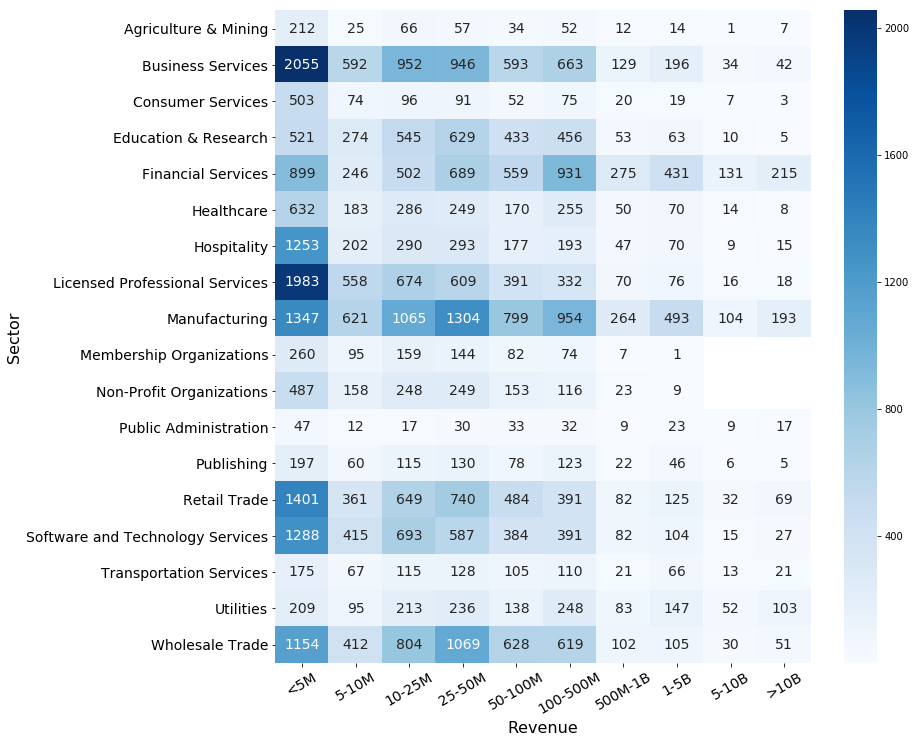

In [144]:
# plot
plt.figure(figsize = (12, 12))
sns.heatmap(plot_data, annot = True, cmap = 'Blues', fmt = 'g', annot_kws = {"size": 14})

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("Sector", fontsize = 16)
plt.xticks(fontsize = 14, rotation = 30)
plt.yticks(fontsize = 14)

### Step 3: Outliers

Top 2 outliers with `total_records_cnt` = 63 and 411. Not sure what causes this.

In [31]:
new_dkim[(new_dkim['total_records_cnt'] == 63) | (new_dkim['total_records_cnt'] == 411)]

,run_date,last_updated,cyence_id,agg_cnt,total_records_cnt,max_public_key_length,min_public_key_length,duration,public_key,company_name,country,cyence_sector,sic4,revenue,income,employees
357134,2018-06-01,2018-07-02,1024314,531,63,704,576,0,1,Berkshire Hathaway Inc.,United States,Financial Services,6719,223604.0,24074.0,367700.0
486932,2018-06-01,2018-07-02,12000000356942,9397,411,704,576,0,1,Hot Pie'S Pies,United Kingdom,Manufacturing,2111,1.0,NaN,1.0


### Step 4: Correlations
#### `total_records_cnt` vs `revenue`

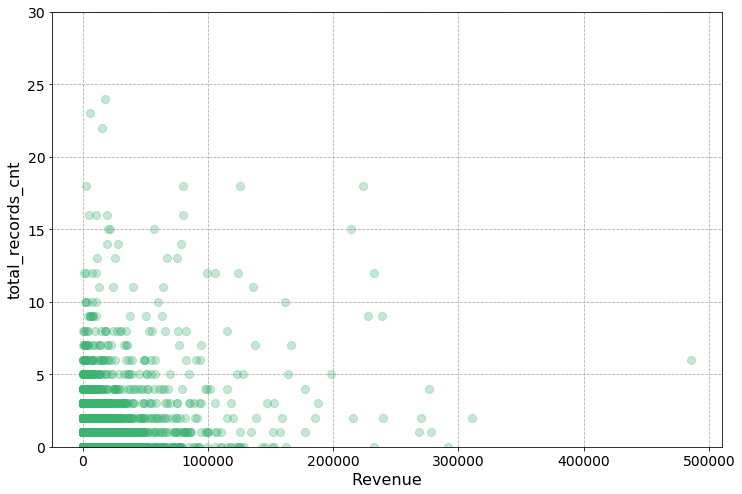

In [126]:
# Scatter plot
plt.figure(figsize = (12, 8))
plt.plot(new_dkim['revenue'] , new_dkim['total_records_cnt'], "o", color = "mediumseagreen", alpha = 0.3, markersize = 8)

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("total_records_cnt", fontsize = 16) 
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim((0, 30))
plt.grid(ls = "--")

# plt.savefig("revenue_agg_cnt.png")

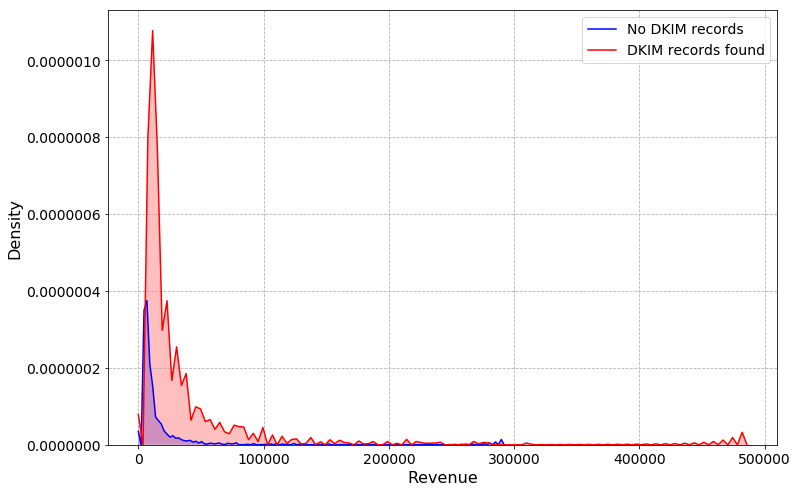

In [127]:
plt.figure(figsize = (12, 8))

# gaussian kernel density estimate
sns.kdeplot(new_dkim[new_dkim['public_key'] == 0]['revenue'], shade = True, color="b", label = "No DKIM records")
sns.kdeplot(new_dkim[new_dkim['public_key'] == 1]['revenue'], shade = True, color="r", label = "DKIM records found")

# settings
plt.legend(prop = {'size': 14})
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(ls = "--")

**Conclusions**
- There is no significant relationship between the existence of DKIM records and the revenue, meaning bigger companies don't necessarily have more DKIM records found

## DMARC
### Step 1: Data
Check the structure of the table.

Metadata: https://cyence.atlassian.net/wiki/spaces/DS/pages/99820036/Data+ID+25+-+Email+DMARC

`pct_good_policy` is calculated by $\frac{\text{dmarc_cnt}}{\text{agg_cnt}}$

In [130]:
dmarc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559106 entries, 0 to 559105
Data columns (total 7 columns):
run_date           559106 non-null object
last_updated       559106 non-null object
cyence_id          559106 non-null int64
agg_cnt            559106 non-null int64
dmarc_cnt          559106 non-null int64
pct_good_policy    559106 non-null float64
avg_pct_checked    559106 non-null float64
dtypes: float64(2), int64(3), object(2)
memory usage: 29.9+ MB


In [136]:
dmarc[dmarc['dmarc_cnt'] != 0].tail()

,run_date,last_updated,cyence_id,agg_cnt,dmarc_cnt,pct_good_policy,avg_pct_checked
559016,2018-06-01,2018-07-01,215875808,7,1,14.0,100.0
559039,2018-06-01,2018-07-01,12000000107281,1,1,100.0,0.0
559059,2018-06-01,2018-07-01,212678655,1,1,100.0,0.0
559086,2018-06-01,2018-07-01,78312981,1,1,100.0,100.0
559105,2018-06-01,2018-07-01,12000000335717,1,1,100.0,0.0


### Step 2: Distributions
#### `dmarc_cnt`: the number of DMARC records found for IPs associated with the Cyence ID
530882/559106 (95%) Cyence IDs don't have valid DMARC records found, which is more than 90%, meaning some companies that have DKIM set up haven't implemented a DMARC policy.

In [148]:
dmarc_cnt_tab = pd.crosstab(index = dmarc['dmarc_cnt'], columns = 'count')
dmarc_cnt_tab
# dmarc_cnt_tab/ dmarc_cnt_tab.sum() 

col_0,count
dmarc_cnt,
0,530882
1,26132
2,1366
3,300
4,138
5,77
6,44
7,39
8,29


#### `policy`: binary indicator

In [137]:
dmarc["policy"] = np.where(dmarc["dmarc_cnt"] != 0, 1, 0)
dmarc.policy.value_counts()

0    530882
1     28224
Name: policy, dtype: int64

In [138]:
# left join DKIM data with company info
new_dmarc = pd.merge(dmarc, companies_info, on = ["cyence_id", "cyence_id"], how = "left")

# Create revenue bins
new_dmarc['revenue_bin'] = '<5M'
new_dmarc.loc[(new_dmarc['revenue'] >= 5) & (new_dmarc['revenue'] < 10), 'revenue_bin'] = '5-10M'
new_dmarc.loc[(new_dmarc['revenue'] >= 10) & (new_dmarc['revenue'] < 25), 'revenue_bin'] = '10-25M'
new_dmarc.loc[(new_dmarc['revenue'] >= 25) & (new_dmarc['revenue'] < 50), 'revenue_bin'] = '25-50M'
new_dmarc.loc[(new_dmarc['revenue'] >= 50) & (new_dmarc['revenue'] < 100), 'revenue_bin'] = '50-100M'
new_dmarc.loc[(new_dmarc['revenue'] >= 100) & (new_dmarc['revenue'] < 500), 'revenue_bin'] = '100-500M'
new_dmarc.loc[(new_dmarc['revenue'] >= 500) & (new_dmarc['revenue'] < 1000), 'revenue_bin'] = '500M-1B'
new_dmarc.loc[(new_dmarc['revenue'] >= 1000) & (new_dmarc['revenue'] < 5000), 'revenue_bin'] = '1-5B'
new_dmarc.loc[(new_dmarc['revenue'] >= 5000) & (new_dmarc['revenue'] < 10000), 'revenue_bin'] = '5-10B'
new_dmarc.loc[new_dmarc['revenue'] >= 10000, 'revenue_bin'] = '>10B'

In [145]:
# heatmap
# Prepare data
plot_data = pd.DataFrame(new_dmarc[new_dmarc['policy'] == 1].groupby(['cyence_sector', 'revenue_bin']).policy.count()).reset_index()

# pivot the dataset to put revenue bins on x axis and sectors on y axis
plot_data = plot_data.pivot('cyence_sector', 'revenue_bin', 'policy') 

plot_data = plot_data[['<5M', '5-10M', '10-25M', '25-50M', '50-100M', '100-500M', '500M-1B', '1-5B', '5-10B', '>10B']]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text yticklabel objects>)

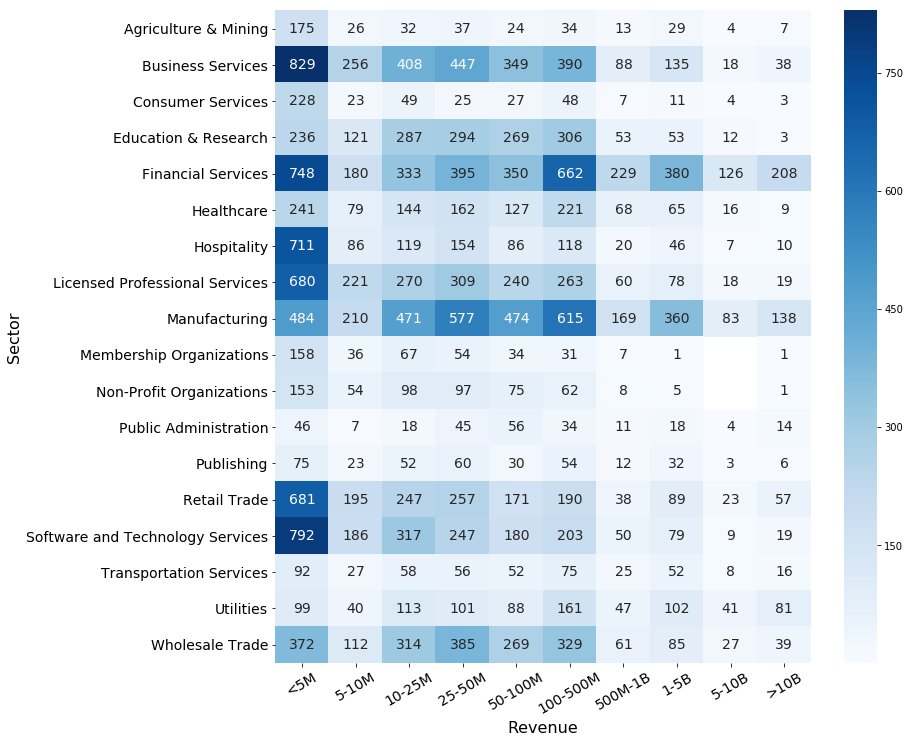

In [147]:
# plot
plt.figure(figsize = (12, 12))
sns.heatmap(plot_data, annot = True, cmap = 'Blues', fmt = 'g', annot_kws = {"size": 14})

# settings
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("Sector", fontsize = 16)
plt.xticks(fontsize = 14, rotation = 30)
plt.yticks(fontsize = 14)

### Step 3: Outliers
A Cyence ID has `dmarc_cnt` = 383. This company also appears in the DKIM outlier list.

In [149]:
new_dmarc[new_dmarc['dmarc_cnt'] == 383]

,run_date,last_updated,cyence_id,agg_cnt,dmarc_cnt,pct_good_policy,avg_pct_checked,policy,company_name,country,cyence_sector,sic4,revenue,income,employees,revenue_bin
486932,2018-06-01,2018-07-01,12000000356942,9397,383,4.0,87.0,1,Hot Pie'S Pies,United Kingdom,Manufacturing,2111,1.0,NaN,1.0,<5M


### Step 4: Correlations
#### `dmarc_cnt` vs `revenue`
The shape of density curves looks very similar.

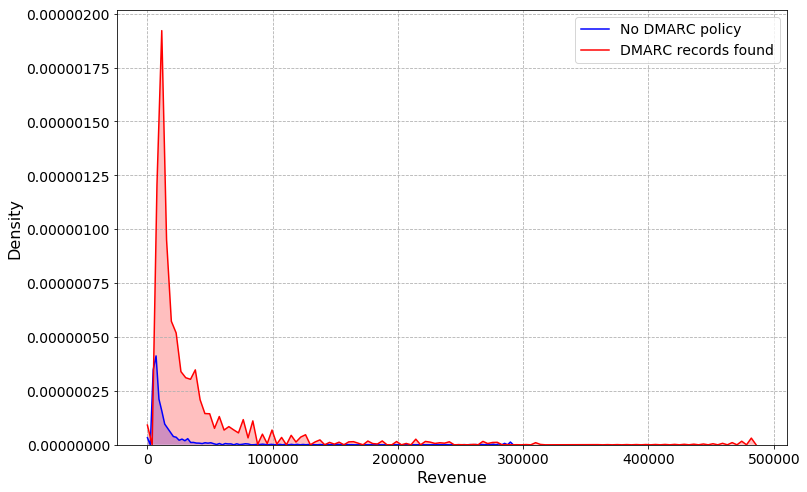

In [150]:
plt.figure(figsize = (12, 8))

# gaussian kernel density estimate
sns.kdeplot(new_dmarc[new_dmarc['policy'] == 0]['revenue'], shade = True, color="b", label = "No DMARC policy")
sns.kdeplot(new_dmarc[new_dmarc['policy'] == 1]['revenue'], shade = True, color="r", label = "DMARC records found")

# settings
plt.legend(prop = {'size': 14})
plt.xlabel("Revenue", fontsize = 16)
plt.ylabel("Density", fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(ls = "--")

# Spot Check
Because DMARC is the policy which tells recipients what to do with messages that fail SPF and/ or DKIM authentication, it is possible that a company with DKIM records doesn't have a DMARC policy. This could be observed by 53564 (#public_key) < 28224 (#policy).

However, there exists three cases.

**1. Has DKIM records but no DMARC policy (43194)**

In [205]:
# Combine DKIM& DMARC
combined = pd.merge(new_dkim[['cyence_id', 'agg_cnt', 'total_records_cnt', 'company_name', 'country', 'cyence_sector', 'revenue', 'employees', 'revenue_bin', 'public_key']], 
                    new_dmarc[['cyence_id', 'policy']], on = ["cyence_id", "cyence_id"])

In [210]:
# combined[(combined['public_key'] == 1) & (combined['policy'] == 0)] # eg: 800164956
combined[combined['cyence_id'] == 800164956]

,cyence_id,agg_cnt,total_records_cnt,company_name,country,cyence_sector,revenue,employees,revenue_bin,public_key,policy
106,800164956,1,1,"INKCYCLE, INC.",United States,Manufacturing,80.434783,490.0,50-100M,1,0


**2. Has DMARC policy but no DKIM records (Shouldn't happen?) (17854)**

In [214]:
# combined[(combined['public_key'] == 0) & (combined['policy'] == 1)] # eg: 77701035
combined[combined['cyence_id'] == 77701035]

,cyence_id,agg_cnt,total_records_cnt,company_name,country,cyence_sector,revenue,employees,revenue_bin,public_key,policy
137,77701035,2,0,Board of Water Supply,United States,Utilities,238.696328,589.0,100-500M,0,1


**3. Has both DMARC& DKIM (10370)**

In [217]:
# combined[(combined['public_key'] == 1) & (combined['policy'] == 1)] # eg: 73284507
combined[combined['cyence_id'] == 73284507]

,cyence_id,agg_cnt,total_records_cnt,company_name,country,cyence_sector,revenue,employees,revenue_bin,public_key,policy
24,73284507,1,1,"AMERICAN HEART ASSOCIATION, INC.",United States,Non-Profit Organizations,780.275142,3500.0,500M-1B,1,1
